# k-Armed Bandit Problems


In this notebook, I will implement different strategies (algorithms) to solve the k-Armed Bandit problem, and you will compare and visually analyze their relative performance differences. The maximum number of points for each subtask is indicated next to the sections.

# Definition of the Problem (Repetition)
k-armed bandit problem definition:
- we repeatedly choose among $k$ different actions
- after each action, we receive a numeric reward
  (originating from a stationary probability distribution, except in the last exercise in this problem set)
- the sole objective: maximize expected total reward over time (by finding and exploiting the most beneficial actions)

The particular **algorithm testbed** we will be using here is defined as follows:
- a set of 2000 randomly generated $10$-armed bandit problems
- for each problem instance, the true action values $q_*(a)$ are sampled from $\mathcal{N}(0,\,1)$ in the beginning
- the actual rewards $R_t$ are sampled from $\mathcal{N}(q_*(a),\,1)$ at each step
- we **don't know** the true action values and hence have to **estimate** them!

## Python Imports & Constants

In [1]:
import numpy as np
import scipy
from scipy.special import softmax
import matplotlib.pyplot as plt
import  matplotlib

print('numpy version:',np.__version__)
print('scipy version:',scipy.__version__)
print('matplotlib version:',matplotlib.__version__)

numpy version: 1.21.5
scipy version: 1.9.2
matplotlib version: 3.5.1


## Definition of k-Armed Bandit Problem
In this section, we implement the actual bandit problem.

In [2]:
class kArmedBandit():
    """
    Specifies a k-armed bandit problem
    
    The agent has to choose from k different actions.
    Taking an action yields a numeric reward specified
    by a stationary probability distribution.
    """
    
    def __init__(self, k=10, seed=None):
        """
        Parameters
        ----------
            @k: the number of actions / arms / levers of the k-armed bandit
            @seed: the seed of the pseudo random number generator (PRNG) that
                   completely specifies this (random) k-armed bandit problem.
                   if you use 'None' for the seed, numpy will use the entropy
                   pool of the operating system to get some true randomness.
                   in the interest of having reproducible experiments, we should
                   always provide a seed here.
        """
        self.k = k
        self.rng = np.random.default_rng(seed)
        # sample the true action values from a gaussian
        # with mean 0 and standard deviation 1.
        
        # these are the values we **don't know**!
        # we'll never use them directly!
        self.q_star = self.rng.normal(0, 1, k)
    
    def step(self, action):
        """
        Take one step, choosing 'action'. This is the **only** method
        that the agent will interact with.
        
        Parameters
        ----------
           @action: action id (integer in [0, k[)
        
        Returns
        -------
            the reward for taking this action.
        """
        # the reward is drawn from a normal distribution with
        # mean q_star[action] and standard deviation 1
        Rt = self.rng.normal(self.q_star[action], 1)
        return Rt
        

## Visualization of one problem instance
This section is <b>just for visualizing</b> the problem instances we are facing.
For this purpose, we generate one instance of the problem and uniformly select actions to get a notion of the underlying stationary probability distribution.

In [3]:
# initialize bandit problem with 10 actions
bandit = kArmedBandit(k=10, seed=1234)

In [4]:
# iterate actions and select each one 1000 times
N_SAMPLES = 1000
action_rewards = np.zeros((N_SAMPLES, bandit.k))
for action in range(bandit.k):
    # choose each action several times and recive reward
    # (this will (hopefully) reveal the underlying distribution)
    for i_sample in range(N_SAMPLES):
        reward = bandit.step(action)
        action_rewards[i_sample, action] = reward
    

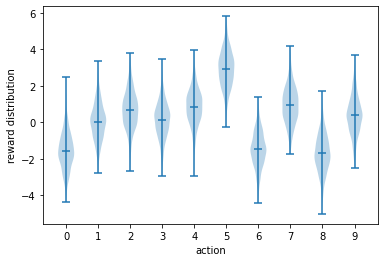

In [5]:
fig, ax = plt.subplots()
ax.violinplot(
    action_rewards,
    np.arange(0, bandit.k),
    showmeans=True,
    showmedians=False,
    showextrema=True
)
ax.set_xlabel('action')
ax.set_xticks(np.arange(0, bandit.k))
ax.set_ylabel('reward distribution')
plt.show()

# Comparison of Standard Algorithms
Your task in this exercise is to compare the bandit algorithms listed below on our standard testbed e.g. the 10-armed bandit problem.
* Iterative Sample Average Method
* Greedy vs. epsilon-Greedy Action Selection
* Optimistic Initial Values
* Upper Confidence Bound Method
* Gradient Bandit Algorithms
* Iterative Sample Average Method with constant step size

## Random Action Selection Baseline
Implementation of a random action selection baseline.

In [7]:
class RandomBaseline():
    def __init__(self, k=10, seed=None):
        """
        Random Action Selection Baseline
        
        This method simply selects an action at random, and does
        not care about rewards at all.
    
        Parameters
        ----------
            @k: number of possible actions (integer)
            @seed: PRNG seed
        """
        # we should definitely remember how many actions there are
        # in order to make a decision ...
        self.k = k
        
        # all of the random behavior of an agent should depend on a
        # PRNG that is initialized in the constructor, given the seed
        
        # whenever your agent has the need for random numbers,
        self.rng = np.random.default_rng(seed)
    
    def choose_action(self):
        """ Action selection is random """
        # we'll use the PRNG that has been initialized in the constructor
        # to draw a uniformly distributed, random integer from the interval [0, k[
        return self.rng.integers(0, self.k)
    
    def update_estimates(self, action, reward):
        """ Because we behave randomly, we don't need to update anything."""
        pass

## Experimental setup
For comparing the implemented methods, we will create similar <b>time step vs. average reward plots</b> as the ones shown in the lecture slides and the book.

In order to facilitate this comparison, we will define a convenience function to run experiments. This enables us to specify an `agent_class` together with its parameters `agent_args` and then run `n_runs` different instances of the k-armed bandit problem for `n_steps` steps, using `agent_class` to solve the problems.

In [8]:
def run_experiments(exp_seed,
                    n_runs=2000,
                    n_steps=1000,
                    k=10,
                    bandit_class=kArmedBandit,
                    agent_class=RandomBaseline,
                    agent_args=dict()):
    """
    Run experiments following the policy of the provided agent.
    
    Parameters
    ----------
    @exp_seed: the seed for the 'mother-PRNG' that produces all other seeds
    @n_runs: number of different bandit problems (integer)
             (to debug your algorithms, you may set this to a lower number.
              don't forget to change it back, once you're done with debugging!)
    @n_steps: number of steps taken in each individual problem (integer)
              (to debug your algorithms, you may set this to a lower number.
              don't forget to change it back, once you're done with debugging!)
    @k: number of actions for the bandit problems (integer)
    @bandit_class: this allows you to change the type of bandit
                   (please only do so for the last problem in this problem set)
    @agent_class: specifies the bandit algorithm to use
    @agent_args: this dictionary of arguments will be passed on
                 to the constructor of the specified bandit algorithm,
                 
                 (with the exception of 'k' and 'seed', as these will be set
                 by the experiment loop)
    
    Returns
    -------
    a numpy array of rewards with shape (n_runs, n_steps), where
    element (i,j) contains the reward in the i-th run, on the j-th step
    """
    args_list = [f'{key}={val}' for key, val in sorted(agent_args.items())]
    args_string = ','.join(args_list)
    print("running {}({})".format(agent_class.__name__, args_string))
    
    # initialize results
    rewards = np.zeros((n_runs, n_steps))

    if isinstance(exp_seed, list):
        exp_seed = exp_seed[0]
    
    # if we're getting entropy, initialize new seed sequence
    if isinstance(exp_seed, int):
        exp_seed_sequence = np.random.SeedSequence(exp_seed)
    elif isinstance(exp_seed, np.random.SeedSequence):
        exp_seed_sequence = exp_seed
    else:
        raise ValueError('please provide SeedSequence or int!')
    
    # perform multiple runs
    for run in range(n_runs):
        # split off 2 new seeds, one for the agent, one for the bandit
        agent_seed, bandit_seed = exp_seed_sequence.spawn(2)

        # instantiate agent, pass it its arguments
        agent = agent_class(k=k, seed=agent_seed, **agent_args)
        
        # get new instance of problem, with new seed
        bandit = bandit_class(k=k, seed=bandit_seed)

        # perform multiple steps on problem instance
        for step in range(n_steps):

            # let the agent pick an action according to its selection strategy
            action = agent.choose_action()

            # the bandit is told the action that the agent chose, and gives out a reward
            reward = bandit.step(action)

            # the agent is told what the reward was for choosing the action
            agent.update_estimates(action, reward)

            # we will record all rewards for later analysis
            rewards[run, step] = reward
    
    print("done!")
    return rewards

### Example Experiments, Random Action Selection
Lets see how well our random action selection baseline performs, and run one experiment.

In [9]:
# run experiments
rewards_random = run_experiments(exp_seed=1234, agent_class=RandomBaseline)

running RandomBaseline()
done!


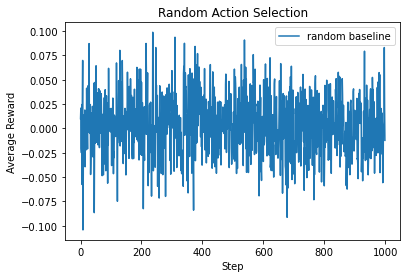

In [10]:
# visualize results
fig, ax = plt.subplots()
ax.plot(
    rewards_random.mean(axis=0),  # average over all runs
    label='random baseline'       # choose a name
)
ax.legend(loc='best')
ax.set_ylabel("Average Reward")
ax.set_xlabel("Step")
ax.set_title("Random Action Selection")
plt.show()

### Run multiple example experiments, collect results
Let's see how we can run multiple experiments, with different parameters.

In [11]:
# for consecutive experiments, having a so-called 'seed sequence', is
# extremely convenient. also look it up in the documentation, to see
# why this is a "really good idea(tm)"!
exp_seed_sequence = np.random.SeedSequence(4711)

# it's convenient to store the experiments in a
# dictionary, so we can iterate over them more easily later on
all_rewards = dict()
all_rewards['algo A, params X, Y, ...'] = run_experiments(
    exp_seed=exp_seed_sequence,
    agent_class=RandomBaseline
)
all_rewards['algo B, params U, V, ...'] = run_experiments(
    exp_seed=exp_seed_sequence,
    agent_class=RandomBaseline
)

# (the algorithms in this example have the same parameters
# but b/c they're completely random anyways, it does not matter)

running RandomBaseline()
done!
running RandomBaseline()
done!


### Visualize multiple results in one plot

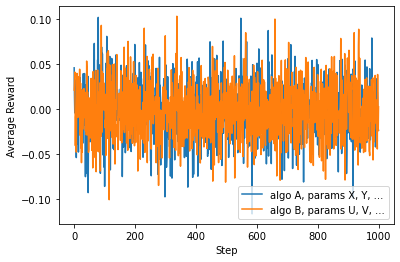

In [11]:
fig, ax = plt.subplots()

for label, rewards in all_rewards.items():
    ax.plot(
        rewards.mean(axis=0),  # average over axis=0, meaning 'over all runs'
        label=label
    )
ax.legend(loc='best')
ax.set_ylabel("Average Reward")
ax.set_xlabel("Step")
plt.show()

---
## 1.1 Incremental Sample Average Method

<div class="alert alert-warning"> 
Implementation of the Sample Average Method (ISAM). The algorithm is parametrized by the number of actions and a probability $\epsilon$ of picking a random action instead of following the policy. Use the optional parameter `initial_value` to implement the "Optimistic Initial Values" trick that encourages exploration.
 </div>

In [12]:
class IncrementalSampleAverageMethod():
    def __init__(self, k=10, epsilon=0.0, initial_value=0.0, seed=None):
        """
        Incremental Implementation of the "Sample Average Method"

        Parameters
        ----------
            @k: number of possible actions (integer)
            @epsilon: probability for selecting a random action (float in the interval [0, 1])
            @initial_value: initial action value estimate (should be used for Optimistic Initial Values)
            @seed: the PRNG seed. the PRNG will help us to decide when to explore and when to exploit
        """
        self.k = k
        self.epsilon = epsilon
        
        # initialize an array with our initial estimates
        self.Q = None
        # YOUR CODE HERE
        self.Q = np.full((self.k,),initial_value)
        
        
        # initialize an array with the action counts
        self.N = np.full((self.k,),0)
        
        # seed the PRNG
        self.rng = np.random.default_rng(seed)
        
    def choose_action(self):
        """ Action selection """
        action = None
        prob_gen = self.rng.uniform(0,np.nextafter(1,2)) 
        
        if self.epsilon > prob_gen:
            action = self.rng.integers(0, self.k)
        
        else:
            action = np.argmax(self.Q)


        return action
    
    def update_estimates(self, action, reward):
        """ Update action value estimate """
        self.N[action] += 1.0
        self.Q[action] = self.Q[action] + (1/self.N[action]) * (reward - self.Q[action])
        

## 1.2 Greedy vs. $\epsilon$-Greedy

In our first experiment, we will explore the influence of the random action selection probability $\epsilon$ on the average reward we get over time.


In [15]:
# run experiments
epsilons = [0., 0.01, 0.1]
exp_seed_sequence = np.random.SeedSequence(1234)

# store the reward squences into this dictionary
all_rewards = {
    'ISAM (purely greedy)': None,
    'ISAM (epsilon = 0.01)': None,
    'ISAM (epsilon = 0.1)': None
}

# use run_experiments to collect the rewards
# run help(run_experiments) to see the function's parameters

all_rewards['ISAM (purely greedy)'] = run_experiments(
    exp_seed=exp_seed_sequence,
    agent_class=IncrementalSampleAverageMethod,
    agent_args = {'epsilon':epsilons[0]}
)


all_rewards['ISAM (epsilon = 0.01)'] = run_experiments(
    exp_seed=exp_seed_sequence,
    agent_class=IncrementalSampleAverageMethod,
    agent_args = {'epsilon':epsilons[1]}
)

all_rewards['ISAM (epsilon = 0.1)'] = run_experiments(
    exp_seed=exp_seed_sequence,
    agent_class=IncrementalSampleAverageMethod,
    agent_args = {'epsilon': epsilons[2]}
)


running IncrementalSampleAverageMethod(epsilon=0.0)
done!
running IncrementalSampleAverageMethod(epsilon=0.01)
done!
running IncrementalSampleAverageMethod(epsilon=0.1)
done!


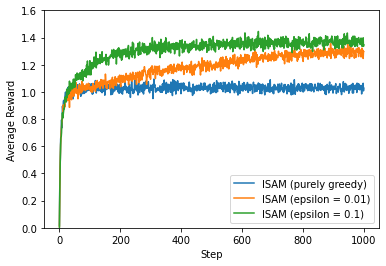

In [17]:
# visualize results
fig, ax = plt.subplots()

for label, rewards in all_rewards.items():
    ax.plot(
        rewards.mean(axis=0),  # average over all runs
        label=label
    )
ax.set_ylim([0.0, 1.6])
ax.legend(loc='best')
ax.set_ylabel("Average Reward")
ax.set_xlabel("Step")
plt.show()

## 1.3 Greedy vs. Optimistic Initial Values
In our second experiment, we evaluate the performance of another approach to encourage exploration, namely Optimistic Initial Values.


In [18]:
# run experiments
exp_seed_sequence = np.random.SeedSequence(1234)

all_rewards = {
    'ISAM (purely greedy)': None,
    'OIV(initial_value=5)': None
}


all_rewards['ISAM (purely greedy)'] = run_experiments(
    exp_seed=exp_seed_sequence,
    agent_class=IncrementalSampleAverageMethod
)


all_rewards['OIV(initial_value=5)'] = run_experiments(
    exp_seed=exp_seed_sequence,
    agent_class=IncrementalSampleAverageMethod,
    agent_args = {'initial_value':5.0}
)

running IncrementalSampleAverageMethod()
done!
running IncrementalSampleAverageMethod(initial_value=5.0)
done!


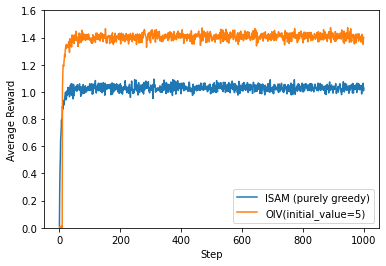

In [20]:
# visualize results
fig, ax = plt.subplots()

for label, rewards in all_rewards.items():
    ax.plot(
        rewards.mean(axis=0),  # average over all runs
        label=label
    )
ax.set_ylim([0.0, 1.6])
ax.legend(loc='best')
ax.set_ylabel("Average Reward")
ax.set_xlabel("Step")
plt.show()

## 2.1 Upper Confidence Bound Action Selection (5 points)

<div class="alert alert-warning"> 
We implement the Upper Confidence Bound Action Selection Method. The algorithm is parametrized by the number of actions and a value $c > 0$ to control the degree of exploration. 
</div>

**Important**: In case of multiple occurrences of the maximum values, the indices corresponding to the first occurrence must be returned.

In [22]:
class UpperConfidenceBound():
    def __init__(self, k=10, c=0.0, seed=None):
        """
        Upper Confidence Bound Action Selection Method
        
        Parameters
        ----------
            @k: number of possible actions (integer)
            @c: parameter that trades off exploration and exploitation
            @seed: for this algorithm, this does not do anything, but it needs
                   to be there, b/c all other constructors have this ...
        """
        self.k = k
        self.c = c
                
        # initialize value function estimates to zero
        self.Q = np.full((self.k,),0.0)
        
        # initialize action counter
        self.N = np.full((self.k,),0.0)

        
    def choose_action(self):
        """ Action selection """
        if any(self.N == 0.0):
            At = np.argmin(self.N)
        else:
            q_array = self.Q + self.c * np.sqrt(np.log(np.sum(self.N) + 1)/self.N)
            At = np.argmax(q_array)
        return At
    
    def update_estimates(self, action, reward):
        """ Update action value estimate """
        self.N[action] += 1.0
        self.Q[action] = self.Q[action] + (1/self.N[action]) * (reward - self.Q[action])


## 2.2 $\epsilon$-Greedy vs Upper Confidence Bound Action Selection 
In our next experiment we compare $\epsilon$-greedy action selection with the *UCB* action selection algorithm.

In [25]:
exp_seed_sequence = np.random.SeedSequence(1234)

# run experiments
all_rewards = {
    '$\epsilon$ = 0.1': None,
    'UCB(c=2)': None
}


all_rewards['$\epsilon$ = 0.1'] = run_experiments(
    exp_seed=exp_seed_sequence,
    agent_class=IncrementalSampleAverageMethod,
    agent_args = {'epsilon':0.1}
)


all_rewards['UCB(c=2)'] = run_experiments(
    exp_seed=exp_seed_sequence,
    agent_class=UpperConfidenceBound,
    agent_args = {'c':2}
)

running IncrementalSampleAverageMethod(epsilon=0.1)
done!
running UpperConfidenceBound(c=2)
done!


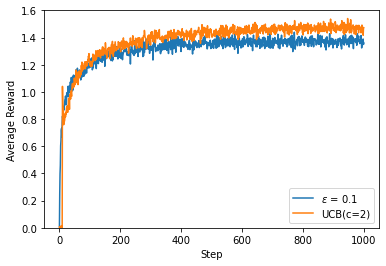

In [31]:
# visualize results
fig, ax = plt.subplots()

for label, rewards in all_rewards.items():
    ax.plot(
        rewards.mean(axis=0),  # average over all runs
        label=label
    )
ax.set_ylim([0.0, 1.6])
ax.legend(loc='best')
ax.set_ylabel("Average Reward")
ax.set_xlabel("Step")
plt.show()

## 3.1 Gradient Bandit Algorithm (5 points)

<div class="alert alert-warning"> 
Implement the Gradient Bandit Algorithm with baseline. The algorithm is parametrized by the number of actions and step size $\alpha$.
</div>

In [26]:
class GradientBandit():
    def __init__(self, k=10, alpha=0.1, seed=None):
        """
        Gradient Bandit Action Selection Method

        Parameters
        ----------
            @k: number of possible actions (integer)
            @alpha: step-size parameter, or learn rate (float)
            @seed: the PRNG seed. it'll be used to sample from the softmax distribution.
        """ 
        self.k = k
        self.alpha = alpha
        self.rng = np.random.default_rng(seed)

        # initialize action selection preferences, baseline and step
        self.H = np.full((self.k,),0.0)
        self.baseline = 0.0
        self.step = 0

        self.actions = np.arange(k)

        
    def choose_action(self):
        """ Action selection """
        # choose action according to preference
        probs = softmax(self.H)
        At = np.random.choice(self.actions, p = probs)
        return At
    
    def update_estimates(self, action, reward):
        """ update action selection preferences """
        self.H[action] = self.H[action] + self.alpha * (reward - self.baseline) * (1- softmax(self.H)[action])
        mask = self.actions != action
        self.H[mask] = self.H[mask] - self.alpha * (reward - self.baseline ) * softmax(self.H)[mask]

        self.step += 1
        self.baseline = self.baseline + (reward - self.baseline) / self.step
        



## 3.2 $\epsilon$-Greedy vs Gradient Bandit (2 points)
In our last experiment we compare $\epsilon$-greedy action selection with the *GradientBandit* algorithm.


In [29]:
# run experiments
exp_seed_sequence = np.random.SeedSequence(1234)

all_rewards = {
    'GB(alpha = 0.01)': None,
    'GB(alpha = 0.1)': None,
    'ISAM(epsilon = 0.1)': None
}


all_rewards['GB(alpha = 0.01)'] = run_experiments(
    exp_seed=exp_seed_sequence,
    agent_class=GradientBandit,
    agent_args = {'alpha':0.01}
)


all_rewards['GB(alpha = 0.1)'] = run_experiments(
    exp_seed=exp_seed_sequence,
    agent_class=GradientBandit,
    agent_args = {'alpha':0.1}
)


all_rewards['ISAM(epsilon = 0.1)'] = run_experiments(
    exp_seed=exp_seed_sequence,
    agent_class=IncrementalSampleAverageMethod,
    agent_args = {'epsilon':0.1}
)



running GradientBandit(alpha=0.01)
done!
running GradientBandit(alpha=0.1)
done!
running IncrementalSampleAverageMethod(epsilon=0.1)
done!


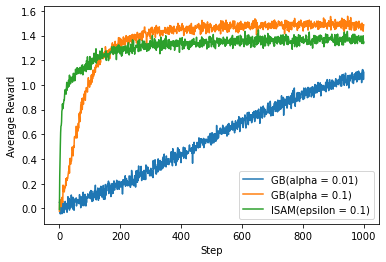

In [31]:
# visualize results
fig, ax = plt.subplots()

for label, rewards in all_rewards.items():
    ax.plot(
        rewards.mean(axis=0),  # average over all runs
        label=label
    )
ax.legend(loc='best')
ax.set_ylabel("Average Reward")
ax.set_xlabel("Step")
plt.show()

# 4. Tracking non-stationary problems
Sample-average methods have difficulties with <b>non-stationary</b> problems. We will use a <b>modified</b> version of the 10-armed bandit, in which all the $q_{\star}(a)$ start out equal and then take independent random walks. This is implemented already below.

<div class="alert alert-warning"> 
You just need to create a <b>modified version</b> of the Incremental Sample Average Method that is able to deal with non-stationary problems.

You will need to run separate experiments for:
- an action-value method using sample averages, incrementally computed by $\alpha=\frac{1}{n}$ (you have that already)
- another action-value method that uses a constant step-size parameter, $\alpha=0.1$ (you still need to create that)

Use an $\epsilon=0.1$ for both methods, and then briefly describe the behavior of the two algorithms.
</div>

In [32]:
class NonstationaryKArmedBandit():
    def __init__(self, k=10, seed=None):
        self.k = k
        self.rng = np.random.default_rng(seed)
        # for the non-stationary bandit problem, all true action
        # values will start out equal
        self.q_star = np.zeros(k)
    
    def step(self, action):
        self.q_star += self.rng.normal(0, 0.01, self.k)
        Rt = self.rng.normal(self.q_star[action], 1)
        return Rt

In [34]:
class ISAM_cs():
    def __init__(self, k=10, epsilon=0.0, initial_value=0.0, alpha=0.1, seed=None):
        self.k = k
        self.epsilon = epsilon
        self.alpha = alpha

        # initialize an array with our initial estimates
        self.Q = np.full((self.k,),initial_value)
        
        # seed the PRNG
        self.rng = np.random.default_rng(seed)
        
    def choose_action(self):
        """ Action selection """
        prob_gen = self.rng.uniform(0,np.nextafter(1,2)) 
        
        if self.epsilon > prob_gen:
            action = self.rng.integers(0, self.k)
        
        else:
            action = np.argmax(self.Q)


        return action
    
    def update_estimates(self, action, reward):
        """ Update action value estimate """
        self.Q[action] = self.Q[action] + self.alpha * (reward - self.Q[action])



In [37]:
# run experiments
exp_seed_sequence = np.random.SeedSequence(4711)

all_rewards = {
    'ISAM(epsilon=0.1)': None,
    'ISAM_cs(epsilon=0.1)': None
    
}

all_rewards['ISAM(epsilon=0.1)'] = run_experiments(
    exp_seed=exp_seed_sequence,
    bandit_class=NonstationaryKArmedBandit,
    agent_class=IncrementalSampleAverageMethod,
    agent_args = {'epsilon':0.1}
)


all_rewards['ISAM_cs(epsilon=0.1)'] = run_experiments(
    exp_seed=exp_seed_sequence,
    bandit_class=NonstationaryKArmedBandit,
    agent_class=ISAM_cs,
    agent_args = {'epsilon':0.1}
)

running IncrementalSampleAverageMethod(epsilon=0.1)
done!
running ISAM_cs(epsilon=0.1)
done!


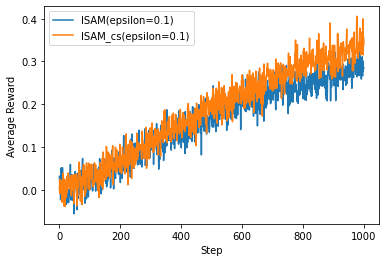

In [39]:
# visualize results
fig, ax = plt.subplots()

for label, rewards in all_rewards.items():
    ax.plot(
        rewards.mean(axis=0),  # average over all runs
        label=label
    )
# ax.set_ylim([0.0, 1.6])
ax.legend(loc='best')
ax.set_ylabel("Average Reward")
ax.set_xlabel("Step")
plt.show()